# Alvin Muhammad Habieb & Aditya Rizaldi - Case Study - Customer Lifetime Values

The Business Development & Marketing team at E-Commerce Olis wants to design loyalty
program, but they still don't have an idea what kind of segment they want
made. They ask you as a data scientist to find out how we are
can judge customers based on their contribution to profits to the company.
You suggest using customer lifetime value to rank
customers based on the value they have provided for the Olist platform.

**Task**


1.   Make RFM segmentation based on the given data. Watch with
good relations between tables (30 points)
2.   Create a customer lifetime value model using the Beta-Geometry model for
predict probability to alive and number of repeat transactions for 7, 14, 30,
and 60 consecutive days. In addition, create a Gamma-Gamma model for make a prediction of the amount of spending or value that will be provided by the customer
per month assuming that the discount rate per month is 1% (30 points) 
3.   (Open-Ended) The results you produce are still too raw because you only
provide a table of values. Make segmentation based on customer value you get and give your argument why you make the segment the way you choose. (40 points)

# Install & Load Packages

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 5.4 MB/s 


In [2]:
# numpy for array manipulation
import numpy as np
# pandas for dataframe manipulation
import pandas as pd
# matplotlib for data visualization
import matplotlib.pyplot as plt

#split training set and test set
from sklearn.model_selection import train_test_split
# import regression model
from sklearn.linear_model import LinearRegression
# import metrics module from scikit-learn
from sklearn import metrics

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

# seaborn for preety data visualization
import seaborn as sns

# import datetime for date manipulation
import datetime as dt

# Load Data

In [24]:
# Customers, Sellers and Olist Geolocation
customer= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_customers_dataset.csv", sep=",", error_bad_lines=False)
seller= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_sellers_dataset.csv", sep=",", error_bad_lines=False)
geolocation= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_geolocation_dataset.csv", sep=",", error_bad_lines=False)

# Product 
product= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_products_dataset.csv", sep=",", error_bad_lines=False)
pro_cat= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/product_category_name_translation.csv", sep=",", error_bad_lines=False)

# Order
order= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_orders_dataset.csv", sep=",", error_bad_lines=False)
order_item= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_items_dataset.csv", sep=",", error_bad_lines=False)
order_payment= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_payments_dataset.csv", sep=",", error_bad_lines=False)
order_review= pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_reviews_dataset.csv", sep=",", error_bad_lines=False)

# Data Inspection

#### Check first 10 first rows of our data

In [25]:
customer.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [26]:
seller.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [27]:
geolocation.head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [28]:
product.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [29]:
pro_cat.head(5)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [30]:
order.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [31]:
order_item.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [32]:
order_payment.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [33]:
order_review.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


#### Check data structure

In [34]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [35]:
seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [36]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [37]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [38]:
pro_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [39]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [40]:
order_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [41]:
order_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [42]:
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


# RFM Segmentation

Behavioral segmentation by 3 important features:

* Recency — number of days since last purchase
* Frequency — the number of transactions made during a certain period
* Monetary — amount spent over a certain period of time


In [43]:
## getting order id by customer purchases 
customer_order=pd.merge(customer, order[['order_id','customer_id','order_purchase_timestamp']],on='customer_id')

## payments in same order id are combined to get total spending on an order
paid=order_payment[['order_id','payment_value']].groupby('order_id').sum().reset_index()

## now the total payment by each order is merged to the cutomer who has bought it to find the total amount purchase
customer_order_rev=pd.merge(customer_order,paid,on='order_id')

## unwanted columns are dropped
customer_order_rev.drop(['customer_zip_code_prefix','customer_city','customer_state'],axis=1,inplace=True)
customer_order_rev['order_purchase_timestamp']=pd.to_datetime(customer_order_rev['order_purchase_timestamp']).dt.date

In [44]:
## find the last date on which customer made the purchase
recency=pd.DataFrame(customer_order_rev.groupby('customer_unique_id')['order_purchase_timestamp'].max())

## we take the maximum date of purchase made by customers as the date to calculate the recency of the purchase
recency['recent_days']=recency['order_purchase_timestamp'].max()-recency['order_purchase_timestamp']
recency['recent_days']=recency['recent_days'].dt.days

## the number of times a unique customer has made purchase
frequency=pd.DataFrame(customer_order_rev.groupby('customer_unique_id')['customer_id'].count())
monetary=pd.DataFrame(customer_order_rev[['customer_unique_id','payment_value']].groupby('customer_unique_id')['payment_value'].sum())

# the receny of visit, total monetary spent and freqency of purchase by each customer is found out and merged
rfm=pd.merge(recency,frequency,on='customer_unique_id')
rfm=pd.merge(rfm,monetary,on='customer_unique_id')

In [45]:
## Freqency - Number of purchase made
## Recency- Days from last purchase
## Monetary-- total amount purchase for by a customer
rfm.drop(['order_purchase_timestamp'],axis=1,inplace=True)
rfm.reset_index(inplace=True)
rfm.columns=['Cust_unique_Id','Recency','Frequency','Monetary']
#use CustomerID as index
rfm.set_index('Cust_unique_Id',inplace=True)
rfm

,Recency,Frequency,Monetary
Cust_unique_Id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
ffff371b4d645b6ecea244b27531430a,617,1,112.46


In the given dataset, we can observe most of the subscriber RFM.

In [46]:
## the descriptive stats for the RFM analysis
rfm.describe()

,Recency,Frequency,Monetary
count,96095.000000,96095.000000,96095.000000
mean,288.103866,1.034809,166.594226
std,153.411050,0.214385,231.428912
min,0.000000,1.000000,0.000000
25%,164.000000,1.000000,63.120000
50%,269.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,773.000000,17.000000,13664.080000


In [47]:
(rfm[rfm['Frequency']>1].shape[0]/96095)*100

3.1187886986835944

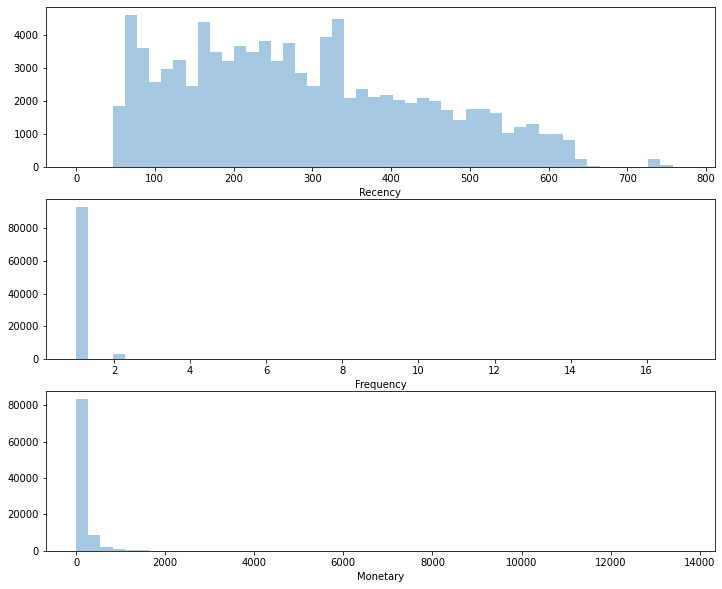

In [48]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'],kde=False)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'],kde=False)
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'],kde=False)
# Show the plot
plt.show()

### RFM Quartiles

The simplest way to segment customers from the RFM Model is to use Quartiles. We assign a score from 1 to 4 for Recency, Frequency, and Monetary. Four is the best/highest score, and one is the lowest/worst score. The final RFM score is calculated simply by combining the individual RFM score numbers.

In [49]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.12, 0.5: 108.0, 0.75: 183.53},
 'Recency': {0.25: 164.0, 0.5: 269.0, 0.75: 397.0}}

In [50]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [51]:
#create rfm segmentation table
rfm_segmentation = rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [52]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Cust_unique_Id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214


In [53]:
rfm_segmentation.sort_values(by='RFMScore', ascending=False)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Cust_unique_Id,,,,,,,
50c7adf7c25188cf27f66e1cfe278fad,69,2,396.68,4,4,4,444
b2e9a05d23ea17713b5d7799f2004f8e,80,3,782.64,4,4,4,444
b3a34bbf1a1d11885918ad3ad99083ae,90,2,360.73,4,4,4,444
6358b15ef7fa9b1210f1a5735cabd3d9,135,4,311.14,4,4,4,444
636443768344855307bfe5f2f2f6ba2e,91,2,353.78,4,4,4,444
...,...,...,...,...,...,...,...
81fef29687c09ae8682508decf649a00,542,1,41.14,1,1,1,111
31b8fa2573bde01af4737e8ed29c348b,399,1,59.34,1,1,1,111
81fcf63a0d321f011729abaa17f28c47,431,1,49.11,1,1,1,111


In [54]:
### how many customers are in each segment

print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  566
Loyal Customers:  2997
Big Spenders:  24021
Almost Lost:  449
Lost Customers:  358
Lost Cheap Customers:  6135


**Heatmap Visualization**

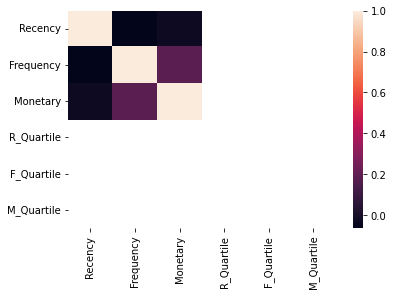

In [55]:
best_cust=rfm_segmentation[rfm_segmentation['RFMScore']=='444']
#calculate and show correlations
corr_matrix = best_cust.corr()
sns.heatmap(corr_matrix)

# Beta-Geometry Model

## Feature Engineering

In [56]:
customer_order_rev

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,252.25
...,...,...,...,...,...
99435,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07,88.78
99436,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04,129.06
99437,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08,56.04
99438,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03,711.07


In [57]:
# Convert Unique Customer ID
array_customerId = customer_order_rev.customer_unique_id.unique()
dict_customerId = dict(enumerate(array_customerId))
res_cid = dict((v,k) for k,v in dict_customerId.items())
customer_order_rev["CustomerID"] = customer_order_rev["customer_unique_id"].map(res_cid)


# Convert Unique Order ID
array_orderId = customer_order_rev.order_id.unique()
dict_orderId = dict(enumerate(array_orderId))
res_oid = dict((v,k) for k,v in dict_orderId.items())
customer_order_rev["OrderID"] = customer_order_rev["order_id"].map(res_oid)

In [58]:
customer_order_rev.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,payment_value,CustomerID,OrderID
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,146.87,0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,335.48,1,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,157.73,2,2
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,173.30,3,3
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,252.25,4,4


In [59]:
print(customer_order_rev.customer_unique_id.nunique())
print(customer_order_rev.CustomerID.nunique())

96095
96095


In [60]:
print(customer_order_rev.order_id.nunique())
print(customer_order_rev.OrderID.nunique())

99440
99440


In [61]:
customer_order_rev['order_purchase_timestamp'] = pd.to_datetime(customer_order_rev['order_purchase_timestamp'])
customer_order_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 99439
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               99440 non-null  object        
 1   customer_unique_id        99440 non-null  object        
 2   order_id                  99440 non-null  object        
 3   order_purchase_timestamp  99440 non-null  datetime64[ns]
 4   payment_value             99440 non-null  float64       
 5   CustomerID                99440 non-null  int64         
 6   OrderID                   99440 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [62]:
customer_order_rev.order_purchase_timestamp.max()

Timestamp('2018-10-17 00:00:00')

In [63]:
data = customer_order_rev[["CustomerID", "order_purchase_timestamp", "payment_value"]]
data

,CustomerID,order_purchase_timestamp,payment_value
0,0,2017-05-16,146.87
1,1,2018-01-12,335.48
2,2,2018-05-19,157.73
3,3,2018-03-13,173.30
4,4,2018-07-29,252.25
...,...,...,...
99435,96090,2018-04-07,88.78
99436,96091,2018-04-04,129.06
99437,96092,2018-04-08,56.04
99438,96093,2017-11-03,711.07


In [64]:
df = summary_data_from_transaction_data(
    data, 
    'CustomerID',
    'order_purchase_timestamp',
    monetary_value_col='payment_value',
    observation_period_end='2018-10-17'
    )

In [65]:
df.query('frequency > 0', inplace=True)

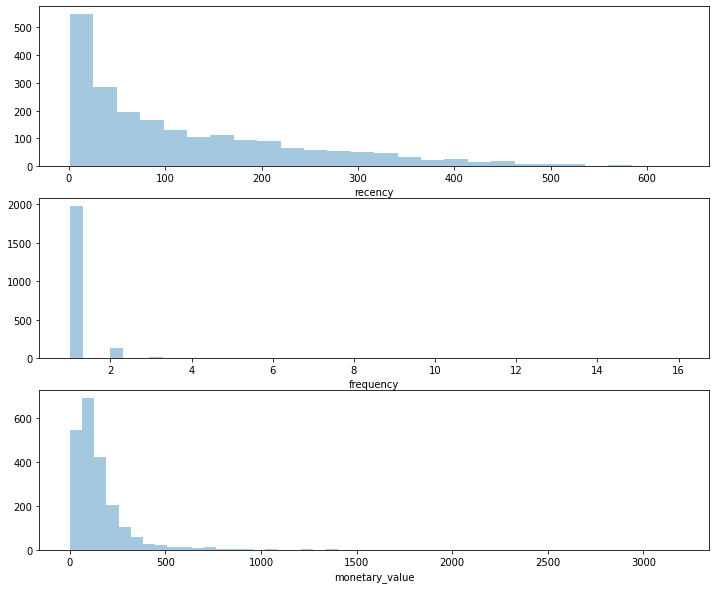

In [66]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df['recency'],kde=False)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df['frequency'],kde=False)
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df['monetary_value'],kde=False)
# Show the plot
plt.show()

In [67]:
print(df['frequency'].describe())
print(sum(df['frequency'] == 1)*100/float(len(df)))

count    2149.000000
mean        1.109353
std         0.528209
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: frequency, dtype: float64
92.27547696603071


In [68]:
print(df['recency'].describe())
print(sum(df['recency'] == 1)*100/float(len(df)))

count    2149.000000
mean      121.761284
std       120.268381
min         1.000000
25%        25.000000
50%        79.000000
75%       187.000000
max       633.000000
Name: recency, dtype: float64
2.1405304792926945


In [69]:
df['monetary_value'].describe()

count    2149.000000
mean      154.282691
std       179.214912
min         0.000000
25%        63.010000
50%       108.330000
75%       179.980000
max      3184.340000
Name: monetary_value, dtype: float64

In [70]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df['frequency'], df['recency'], df['T'])

<lifetimes.BetaGeoFitter: fitted with 2149 subjects, a: 2.85, alpha: 1340.67, b: 0.30, r: 12.74>

Check model summary

In [71]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,12.735529,4.491768,3.931664,21.539395
alpha,1340.668825,506.350814,348.221229,2333.116421
a,2.851000,0.579242,1.715686,3.986315
b,0.302773,0.068109,0.169279,0.436267


### Visualizing The Frequency and Recency Matrix

Let's do some hypothetical analysis:
* Customers who buy daily for four consecutive weeks, and no transactions in several months; chances are that the customer is still alive is less.
* On the other hand, customers who have historically made purchases once in a quarter, and again in the last quarter, are likely still alive. We can visualize this relationship using a frequency/recency matrix, which calculates the approximate number of transactions that a dummy customer will make in the next time period, given recency (age at last purchase) and frequency (number of repeat transactions made).

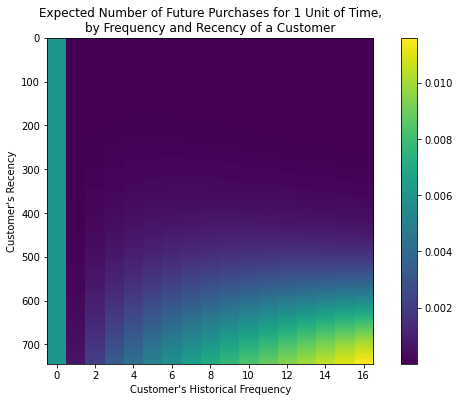

In [72]:
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

We can see that, if a customer has made 16 purchases, and their last purchase was about 700 days ago (i.e. Recency: the duration between their first transaction and their last transaction was 700 days), then they are our best customer. (bottom right).

Customers who have bought a lot and bought recently are likely to be the best customers in the future. We will never have enough of them.

Customers who have bought a lot but not recently (top right corner), are probably gone. There is also another type of customer which is around (2, 100) which represents customers who buy less frequently, and we haven't seen them recently, so they will probably buy again. However, we're not sure if they're gone or just between purchases.

Another interesting matrix to look at is the probability of being alive:

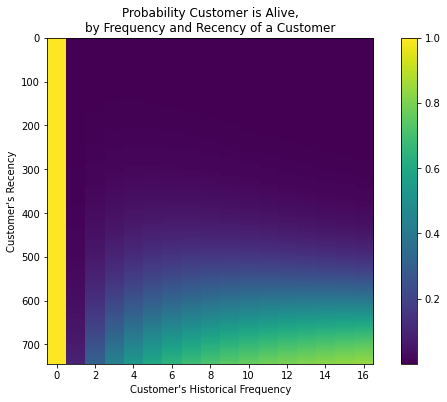

In [73]:
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

- Customers who have recently purchased are almost certainly "alive".
- Customers who have purchased a lot but not recently, have most likely left the app. And the more they bought in the past, the more likely they were to be dropped out. They are represented at the bottom right.

### Ranking customers from best to worst
Let's go back to our customers and rank them from "highest expected purchase in the next period" to lowest. The model exposes a method that will predict a customer's expected purchase in the next period using their history.

In [74]:
# Purchases Expectation after 7 days 
t = 7
# predict purchases
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df['frequency'], df['recency'], df['T']
)

df['prob_alive'] = bgf.conditional_probability_alive(
    df['frequency'], df['recency'], df['T']
)

df.sort_values(by='predicted_purchases', ascending = False).head(10)

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,
14104,16.0,462.0,520.0,56.553750,0.073290,0.683602
8855,5.0,418.0,473.0,151.606000,0.031527,0.466409
2023,4.0,236.0,299.0,149.282500,0.026430,0.375520
16760,5.0,282.0,393.0,133.412000,0.022490,0.318228
26098,6.0,235.0,373.0,138.941667,0.021042,0.278400
28989,2.0,54.0,68.0,197.550000,0.020271,0.282853
23547,2.0,31.0,52.0,94.630000,0.019391,0.267555
3812,3.0,400.0,462.0,70.680000,0.019125,0.317718
23640,3.0,381.0,446.0,93.070000,0.018869,0.310733


In [75]:
df.query('predicted_purchases > 0.5')

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,


In [76]:
# Purchases Expectation after 14 days 
t = 14
# predict purchases
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df['frequency'], df['recency'], df['T']
)

df['prob_alive'] = bgf.conditional_probability_alive(
    df['frequency'], df['recency'], df['T']
)

df.sort_values(by='predicted_purchases', ascending = False).head(10)

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,
14104,16.0,462.0,520.0,56.553750,0.145377,0.683602
8855,5.0,418.0,473.0,151.606000,0.062272,0.466409
2023,4.0,236.0,299.0,149.282500,0.052080,0.375520
16760,5.0,282.0,393.0,133.412000,0.044398,0.318228
26098,6.0,235.0,373.0,138.941667,0.041565,0.278400
28989,2.0,54.0,68.0,197.550000,0.039692,0.282853
23547,2.0,31.0,52.0,94.630000,0.037958,0.267555
3812,3.0,400.0,462.0,70.680000,0.037686,0.317718
23640,3.0,381.0,446.0,93.070000,0.037178,0.310733


In [77]:
df.query('predicted_purchases > 0.5')

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,


In [78]:
# # Purchases Expectation after 30 days 
t = 30
# predict purchases
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df['frequency'], df['recency'], df['T']
)

df['prob_alive'] = bgf.conditional_probability_alive(
    df['frequency'], df['recency'], df['T']
)

df.sort_values(by='predicted_purchases', ascending = False).head(10)

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,
14104,16.0,462.0,520.0,56.553750,0.305765,0.683602
8855,5.0,418.0,473.0,151.606000,0.129740,0.466409
2023,4.0,236.0,299.0,149.282500,0.107932,0.375520
16760,5.0,282.0,393.0,133.412000,0.092383,0.318228
26098,6.0,235.0,373.0,138.941667,0.086616,0.278400
28989,2.0,54.0,68.0,197.550000,0.081111,0.282853
3812,3.0,400.0,462.0,70.680000,0.078105,0.317718
23547,2.0,31.0,52.0,94.630000,0.077528,0.267555
23640,3.0,381.0,446.0,93.070000,0.077029,0.310733


In [79]:
df.query('predicted_purchases > 0.5')

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,


In [80]:
# Purchases Expectation after 60 days 
t = 60
# predict purchases
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df['frequency'], df['recency'], df['T']
)

df['prob_alive'] = bgf.conditional_probability_alive(
    df['frequency'], df['recency'], df['T']
)

df.sort_values(by='predicted_purchases', ascending = False).head(10)

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,
14104,16.0,462.0,520.0,56.553750,0.590930,0.683602
8855,5.0,418.0,473.0,151.606000,0.246510,0.466409
2023,4.0,236.0,299.0,149.282500,0.203156,0.375520
16760,5.0,282.0,393.0,133.412000,0.175139,0.318228
26098,6.0,235.0,373.0,138.941667,0.164638,0.278400
28989,2.0,54.0,68.0,197.550000,0.148950,0.282853
3812,3.0,400.0,462.0,70.680000,0.147010,0.317718
23640,3.0,381.0,446.0,93.070000,0.144911,0.310733
18303,3.0,421.0,486.0,532.320000,0.143388,0.313525


In [81]:
df.query('predicted_purchases > 0.5')

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,
14104,16.0,462.0,520.0,56.55375,0.59093,0.683602


The conclusion from the prediction results of the model above, our company is not doing well, even though its customers have a high engagement rate **but**, when it is predicted whether they will return to transactions, **more than 2 months at most** again they will re-transact.

Listed above are our top 10 customers the model expects to make a purchase the next day. We can see that customers who have made 16 purchases, and recently purchased from us, may buy again in the next period.

The purchase_prediction column represents the number of expected purchases, while the other three columns represent the current RF metric. The BG/NBD model believes that these people will be making more purchases in the near future because they are our best customers right now.

#### Assessing model fit
So far, we can predict and visualize the behavior of our customers. Now let's assess the correctness of the model. The first is to compare your data with the simulated artificial data with the model parameters we installed.

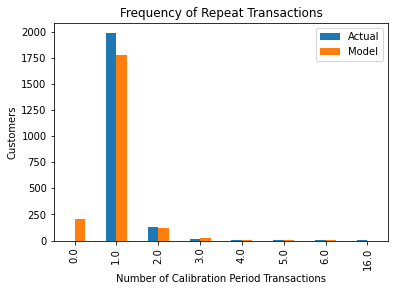

In [82]:
plot_period_transactions(bgf, max_frequency=7)

We can see that our actual data and simulated data line up well. So, we can continue our analysis. We now partition the dataset into a calibration period dataset and a holdout dataset. This is important because we want to test the performance of our model on data that is not yet visible (such as cross-validation in machine learning practices).

### More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important because we want to test the performance of our model on data that has yet to be seen (think cross-validation in the standard machine learning literature).

In [83]:
pd.get_option("display.max_columns")
summary_cal_holdout = calibration_and_holdout_data(
    data, 'CustomerID', 'order_purchase_timestamp',
    calibration_period_end='2018-04-17',
    observation_period_end='2018-10-17'
)

In [84]:
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
0                     0.0          0.0  336.0                0.0   
1                     0.0          0.0   95.0                0.0   
3                     0.0          0.0   35.0                0.0   
5                     1.0         31.0  215.0                0.0   
6                     0.0          0.0   57.0                0.0   

            duration_holdout  
CustomerID                    
0                      183.0  
1                      183.0  
3                      183.0  
5                      183.0  
6                      183.0  


With this dataset, we can perform ﬁtting on the _cal columns, and test on the _holdout columns:


In [85]:
bgf = BetaGeoFitter(penalizer_coef=0)

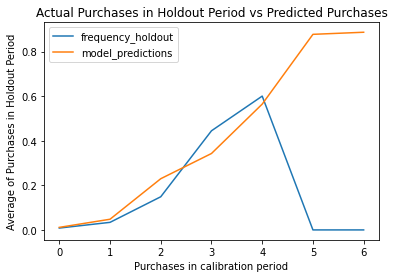

In [86]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into sample (calibration) and validation (holding) periods. The sample period consists of early 2018-04-17; validation period lasts from 2018-04-17 to 2018-10-17. The plot groups all customers in the calibration period based on the number of repeat purchases (x-axis) and then the average over their repeat purchases in the hold period (y-axis). The orange and blue lines represent model predictions and actual results from the y-axis, respectively. As we can see, our model is able to predict the behavior of the customer base from the sample, the model is under-estimated at 4 purchases.

### Customer transactions predictions
Based on customer history, we can now predict what individual purchases will look like in the future:

In [87]:
t = 10 #predict purchases in 10 periods 
individual = df.loc[14104]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time` 
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.16583819289604582

In [88]:
t = 66 #predict purchases in 66 periods 
individual = df.loc[14104]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time` 
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.0140391307453749

Our model predicts that customer 14104's future transaction probability is 0.165 in these 10 days is very small.
**but when** we predict **more than 2 months** like the prediction above, then the number becomes 1, meaning that he will trade 1 time

In [89]:
t = 66 #predict purchases in 10 periods 
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time` 
bgf.predict(t, df['frequency'], df['recency'], df['T'])

CustomerID
5        0.004799
13       0.018262
32       0.012913
88       0.018260
116      0.013028
           ...   
92041    0.012430
92490    0.014626
92957    0.009467
93384    0.004941
94647    0.005512
Length: 2149, dtype: float64

#### Customer probability histories

Given a customer's transaction history, we can calculate their historical probability of survival, according to our trained model. For example, we want to look at the transaction history of our best customers and see if they are still alive:

In [90]:
t = 1
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df['frequency'], df['recency'], df['T'])
best_projected_cust = df.sort_values('predicted_purchases').tail(6)
df.sort_values(by='predicted_purchases').tail(6)

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive
CustomerID,,,,,,
1086,2.0,19.0,49.0,84.58000,0.004985,0.248848
2023,4.0,236.0,299.0,149.28250,0.005085,0.375520
8855,5.0,418.0,473.0,151.60600,0.005419,0.466409
28989,2.0,54.0,68.0,197.55000,0.005553,0.282853
23547,2.0,31.0,52.0,94.63000,0.005635,0.267555
14104,16.0,462.0,520.0,56.55375,0.016799,0.683602


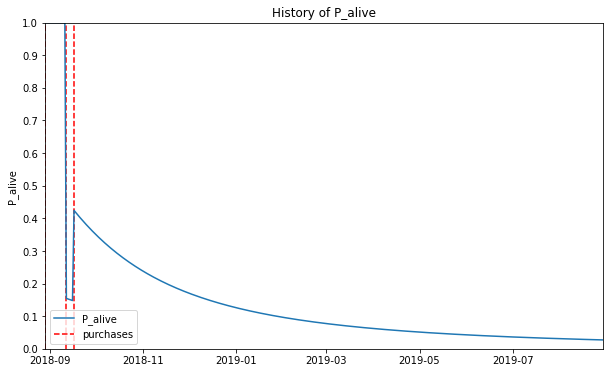

In [91]:
fig = plt.figure(figsize=(10,6))
id = 1086
days_since_birth = 365
sp_trans = data.loc[data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'order_purchase_timestamp')
plt.show()

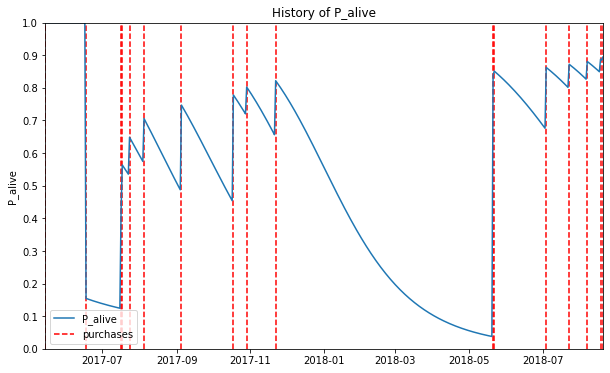

In [92]:
fig = plt.figure(figsize=(10,6))
id = 14104
days_since_birth = 365
sp_trans = data.loc[data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'order_purchase_timestamp')
plt.show()

# Gamma-Gamma Model

The Gamma-Gamma model is based on the assumption that the number of transactions does not depend on the monetary value. Frequency and monetary value are uncorrelated if output is close to zero. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between monetary value and purchase frequency. In practice we need to check if the Pearson correlation between two vectors is close to 0 to use this model.

##Estimated customer lifetime value using gamma-gamma monetary value model

So far, we do not take into account the economic value of each transaction and we focus more on transaction events. To estimate this we can use the Gamma-Gamma submodel. But first we need to create a data summary of the transactional data that also contains the economic value for each transaction (i.e. profit or revenue).

As we now know that, to create a summary data set that contains information about each customer. We can use the summary_data_from_transaction_data function to generate a summary data frame.

The result contains four columns:

- recency — time between first and last transaction

- frequency — the number of purchases beyond the initial one

- T — the time between the first purchase and the end of the calibration period

- monetary value — arithmetic average of customer transactions in the calibration period

If we have some customers who bought nothing in the calibration period and their monetary value in the summary data set is zero, we have to delete them. After that we can build the model. We only estimate customers who have had at least one repeat purchase with us. Therefore, we estimate for 2148 subscribers.

In [93]:
summary = df[(df['frequency']>0) & (df['monetary_value']>0)]
print(summary.head())
print()
print('\nCustomers with atleast 1 repeat purchase\n', len(summary))

            frequency  recency      T  monetary_value  predicted_purchases  \
CustomerID                                                                   
5                 1.0     31.0  398.0          283.67             0.000079   
13                1.0     91.0  224.0          245.11             0.000312   
32                1.0     44.0  226.0           67.05             0.000220   
88                1.0     26.0  154.0          228.49             0.000323   
116               1.0     51.0  234.0           95.40             0.000222   

            prob_alive  
CustomerID              
5             0.004074  
13            0.030395  
32            0.019102  
88            0.030115  
116           0.019089  


Customers with atleast 1 repeat purchase
 2148


In [94]:
summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.009424
frequency,0.009424,1.000000


It seems that we can use summary to estimate CLTV. We can train our Gamma-Gamma submodel and predict the expected conditional average lifespan of our customers.

In [95]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary['frequency'],
        summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2148 subjects, p: 6.10, q: 2.73, v: 43.99>


After applying the Gamma-Gamma model, we can now estimate the average transaction value for each customer.

In [96]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

CustomerID
5      255.279493
13     225.237077
32      86.509050
88     212.288296
116    108.596770
132     80.424214
134    284.106501
197    319.018345
214    147.131468
222    190.979684
dtype: float64


In [97]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 154.6476200786505, Average profit: 154.35451749689634


Meanwhile, to calculate the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_ﬂow) adjusted for the cost of capital:

In [98]:
# refit the BG model to the summary_with_money_value dataset 
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(ggf.customer_lifetime_value( 
    bgf, #the model to use to predict the number of future transactions 
    summary['frequency'], 
    summary['recency'], 
    summary['T'], 
    summary['monetary_value'], time=12, # months 
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually 
).head(10))

CustomerID
5      1.260216
13     8.622840
32     2.081407
88     8.184643
116    2.606170
132    0.613613
134    1.177264
197    1.439081
214    1.154697
222    7.882086
Name: clv, dtype: float64


# Customer Segmentation

Instead of analysing the entire customer base as a whole, Olist's marketing team would like to understand the behaviour of each customer segment. A customer segmentation model (RFM framework) will allow Olist to identify users and target them with differentiated and personalised marketing strategies. This will improve user engagement and retention.

## Import Libraries

In [99]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

## Import Data

In [100]:
customers = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_customers_dataset.csv", sep=",", error_bad_lines=False)

orders = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_orders_dataset.csv", sep=",", error_bad_lines=False, 
                     parse_dates=[
                         'order_purchase_timestamp', 
                         'order_approved_at', 
                         'order_delivered_carrier_date',
                         'order_delivered_customer_date',
                         'order_estimated_delivery_date'
                     ]
                    )

order_items = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_items_dataset.csv", 
                          parse_dates=[
                              'shipping_limit_date'
                          ]
                         )
order_payments = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_payments_dataset.csv")

In [101]:
dfs = [customers, orders, order_items, order_payments]

# Print shape of our datasets
for df in dfs:
    print(df.shape)

(99441, 5)
(99441, 8)
(112650, 7)
(103886, 5)


## Data Cleaning

In [102]:
# Merge 4 datasets into 1 dataframe
df1 = order_items.merge(order_payments, on='order_id')
df2 = df1.merge(orders, on='order_id')
df = df2.merge(customers, on='customer_id')

In [103]:
# Check for null values
df.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [104]:
df[df['order_delivered_customer_date'].isnull()]['order_status'].value_counts()

shipped        1244
canceled        559
processing      375
invoiced        371
delivered         8
unavailable       7
approved          3
Name: order_status, dtype: int64

In [105]:
# We will only keep orders that were delivered
df = df[df['order_status']=='delivered']

In [106]:
df.isnull().sum()

order_id                          0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
payment_sequential                0
payment_type                      0
payment_installments              0
payment_value                     0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
dtype: int64

## RFM Methodology

We will use the RFM framework to build our customer segmentation model. RFM stands for Recency, Frequency, Monetary Value. This would allow us to create the following segments:

* Low Value: Customers who are less active than others, not very frequent buyers and generate very low revenue.
* Mid Value: In the middle of everything. Uses the platform fairly frequently and generates moderate revenue.
* High Value: The group we don’t want to lose. High Revenue, Frequency and Low Inactivity.

### Recency
Recency can be calculated by finding the number of days since customers' last purchase. After obtaining the number of inactive days, we can apply K-means clustering to assign each customer a recency score.

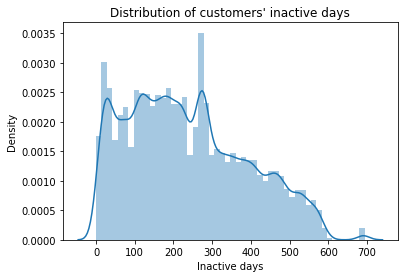

In [107]:
# Create a dataframe to store customers uuid and recency scores
recency = df[['customer_unique_id', 'order_purchase_timestamp']].copy()

# Since a customer may have more than one order, we will obtain his/her last purchase timestamp
recency = recency.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_timestamp']

# Calculate the number of days since customers' last purchase
recency['inactive_days'] = (recency['last_purchase_timestamp'].max() - recency['last_purchase_timestamp']).dt.days
recency.drop(columns='last_purchase_timestamp', inplace=True)

sns.distplot(recency['inactive_days'], bins=50)
plt.xlabel('Inactive days')
plt.ylabel('Density')
plt.title("Distribution of customers' inactive days");

We will use K-means clustering to assign each customer with a recency score. But first, we will use the elbow method to identify the optimal number of clusters here.

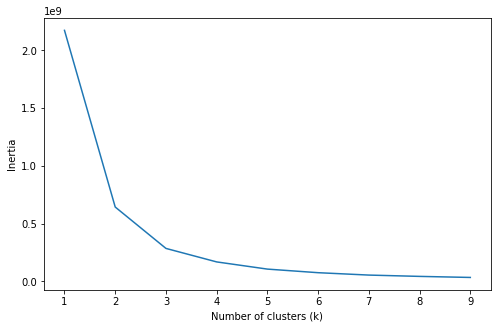

In [108]:
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(recency[['inactive_days']])
    inertia[k] = km.inertia_

plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia');

Given that the elbow on the arm is the optimal k, the optimal number of clusters for Recency is 3. However, as we would see later on, the optimal k for Frequency and Monetary is 4. Hence, we will go with 4 clusters for consistency.

In [109]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(recency[['inactive_days']])
recency['cluster'] = km.labels_

recency.head()

,customer_unique_id,inactive_days,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1
2,0000f46a3911fa3c0805444483337064,536,2
3,0000f6ccb0745a6a4b88665a16c9f078,320,0
4,0004aac84e0df4da2b147fca70cf8255,287,0


In [110]:
recency.groupby('cluster')['inactive_days'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,25348.0,61.224712,35.810246,0.0,28.0,61.0,94.0,121.0
3,27129.0,182.690368,35.207229,122.0,153.0,182.0,213.0,247.0
0,24270.0,313.020766,43.167006,248.0,276.0,306.0,350.0,397.0
2,16610.0,482.513666,58.840875,398.0,435.0,474.0,525.0,694.0


As seen above, the cluster labels do not intuitively represent the inactive days. Let's assign cluster 0 to the highly inactive customers and cluster 4 to the most active customers.


In [111]:
# Renaming the clusters according to mean number of inactive_days
recency_cluster = recency.groupby('cluster')['inactive_days'].mean().reset_index()
recency_cluster = recency_cluster.sort_values(by='inactive_days', ascending=False).reset_index(drop=True)
recency_cluster['index'] = np.arange(0,4)
recency_cluster.set_index('cluster', inplace=True)
cluster_dict = recency_cluster['index'].to_dict()
recency['cluster'].replace(cluster_dict, inplace=True)

# Check that the clusters have been renamed correctly
recency.head()

,customer_unique_id,inactive_days,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,111,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,3
2,0000f46a3911fa3c0805444483337064,536,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,1
4,0004aac84e0df4da2b147fca70cf8255,287,1


In [112]:
recency.groupby('cluster')['inactive_days'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
3,25348.0,61.224712,35.810246,0.0,28.0,61.0,94.0,121.0
2,27129.0,182.690368,35.207229,122.0,153.0,182.0,213.0,247.0
1,24270.0,313.020766,43.167006,248.0,276.0,306.0,350.0,397.0
0,16610.0,482.513666,58.840875,398.0,435.0,474.0,525.0,694.0


So, the cluster labels now make more sense. Cluster 3 are our most valued customers as they have completed a more recent transaction compared to customers from the other clusters.


### Frequency
We will count the number of unique orders made by each customer to obtain their purchase frequencies.

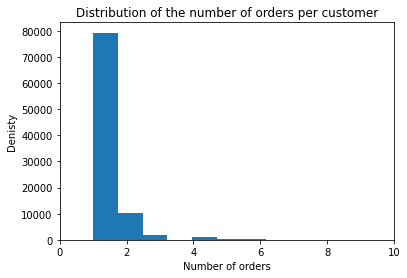

In [113]:
# Create a dataframe to store customers uuid and frequency scores
frequency = df[['customer_unique_id', 'order_id']].copy()

# Count the number of orders for each customer
frequency = frequency.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['customer_unique_id', 'number_of_orders']

frequency['number_of_orders'].plot.hist(bins=100)
plt.xlim(0,10)
plt.xlabel('Number of orders')
plt.ylabel('Denisty')
plt.title('Distribution of the number of orders per customer');

We will use K-means clustering to assign each customer with a recency score. But first, we will use the elbow method to identify the optimal number of clusters here.

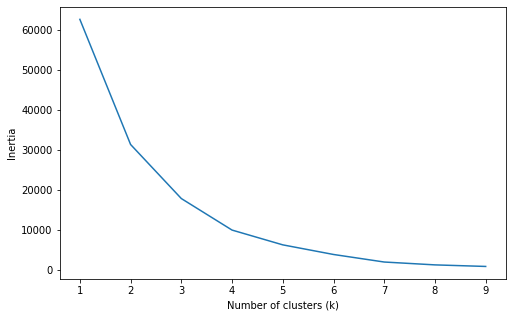

In [114]:
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(frequency[['number_of_orders']])
    inertia[k] = km.inertia_

plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia');

The optimal number of clusters for Frequency is 4.


In [115]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(frequency[['number_of_orders']])
frequency['cluster'] = km.labels_

frequency.groupby('cluster')['number_of_orders'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,79337.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,12325.0,2.154970,0.361890,2.0,2.0,2.0,2.0,3.0
1,1662.0,5.081829,1.695493,4.0,4.0,4.0,6.0,13.0
3,33.0,20.969697,11.303995,14.0,15.0,19.0,22.0,75.0


Just like Recency, the given cluster labels in Frequency are not intuitive.

We will reassign the labels here. Customers that have made only 1 order will be assigned to cluster 0 while the cluster that has an average of 14.5 orders will be assigned to cluster 3.

In [116]:
# Renaming the clusters according the mean number_of_orders
frequency_cluster = frequency.groupby('cluster')['number_of_orders'].mean().reset_index()
frequency_cluster = frequency_cluster.sort_values(by='number_of_orders').reset_index(drop=True)
frequency_cluster['index'] = np.arange(0,4)
frequency_cluster.set_index('cluster', inplace=True)
cluster_dict = frequency_cluster['index'].to_dict()
frequency['cluster'].replace(cluster_dict, inplace=True)

frequency.groupby('cluster')['number_of_orders'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,79337.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,12325.0,2.154970,0.361890,2.0,2.0,2.0,2.0,3.0
2,1662.0,5.081829,1.695493,4.0,4.0,4.0,6.0,13.0
3,33.0,20.969697,11.303995,14.0,15.0,19.0,22.0,75.0


As seen above, the cluster labels do not intuitively represent the inactive days. Let's assign cluster 0 to the highly inactive customers and cluster 4 to the most active customers.


In [117]:
# Renaming the clusters according the mean number_of_orders
frequency_cluster = frequency.groupby('cluster')['number_of_orders'].mean().reset_index()
frequency_cluster = frequency_cluster.sort_values(by='number_of_orders').reset_index(drop=True)
frequency_cluster['index'] = np.arange(0,4)
frequency_cluster.set_index('cluster', inplace=True)
cluster_dict = frequency_cluster['index'].to_dict()
frequency['cluster'].replace(cluster_dict, inplace=True)

frequency.groupby('cluster')['number_of_orders'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,79337.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,12325.0,2.154970,0.361890,2.0,2.0,2.0,2.0,3.0
2,1662.0,5.081829,1.695493,4.0,4.0,4.0,6.0,13.0
3,33.0,20.969697,11.303995,14.0,15.0,19.0,22.0,75.0


Cluster 3 are the highest frequency customers.


### Monetary

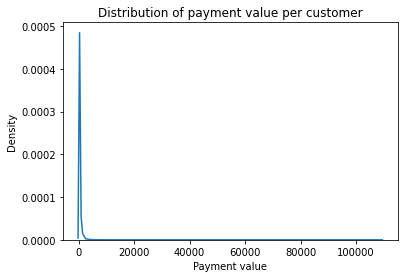

In [118]:
# Create a dataframe to store customer uuid and monetary scores
monetary = df[['customer_unique_id', 'payment_value']].copy()

# Total payment value per customer
monetary = monetary.groupby('customer_unique_id')['payment_value'].sum().reset_index()

sns.distplot(monetary['payment_value'], hist=False)
plt.xlabel('Payment value')
plt.ylabel('Density')
plt.title('Distribution of payment value per customer');

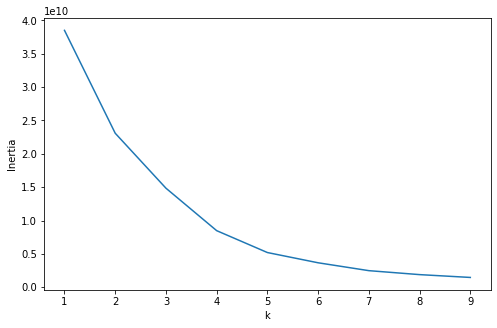

In [119]:
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(monetary[['payment_value']])
    inertia[k] = km.inertia_

plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('k')
plt.ylabel('Inertia');

In [120]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(monetary[['payment_value']])
monetary['cluster'] = km.labels_

monetary

,customer_unique_id,payment_value,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0
2,0000f46a3911fa3c0805444483337064,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,196.89,0
...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84,1
93353,fffea47cd6d3cc0a88bd621562a9d061,84.58,0
93354,ffff371b4d645b6ecea244b27531430a,112.46,0
93355,ffff5962728ec6157033ef9805bacc48,133.69,0


In [121]:
monetary.groupby('cluster')['payment_value'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,92133.0,173.271747,192.630821,9.59,63.27,111.43,195.960,1436.46
1,1203.0,2692.243400,1668.973782,1436.84,1679.72,2065.35,2993.200,12490.88
2,20.0,23201.656000,9512.025508,14196.28,16880.72,19258.32,28226.475,45256.00
3,1.0,109312.640000,NaN,109312.64,109312.64,109312.64,109312.640,109312.64


We can analyze that the assigned cluster labels do best represent customers' monetary value. We will rename these clusters.

In [122]:
# Renaming the clusters according to mean number of payment_value
monetary_cluster = monetary.groupby('cluster')['payment_value'].mean().reset_index()
monetary_cluster = monetary_cluster.sort_values(by='payment_value').reset_index(drop=True)
monetary_cluster['index'] = np.arange(0,4)
monetary_cluster.set_index('cluster', inplace=True)
cluster_dict = monetary_cluster['index'].to_dict()
monetary['cluster'].replace(cluster_dict, inplace=True)

monetary.groupby('cluster')['payment_value'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,92133.0,173.271747,192.630821,9.59,63.27,111.43,195.960,1436.46
1,1203.0,2692.243400,1668.973782,1436.84,1679.72,2065.35,2993.200,12490.88
2,20.0,23201.656000,9512.025508,14196.28,16880.72,19258.32,28226.475,45256.00
3,1.0,109312.640000,NaN,109312.64,109312.64,109312.64,109312.640,109312.64


Clusters 2 and 3 are our biggest spending customers.

### Overall Scores

In [123]:
# Merge recency, frequency and monetary dataframes together on customer uuid
overall = recency.merge(frequency, on='customer_unique_id')
overall = overall.merge(monetary, on='customer_unique_id')

# Rename cluster columns
overall.rename(columns={'cluster_x': 'recency_cluster',
                       'cluster_y': 'frequency_cluster',
                       'cluster': 'monetary_cluster'},
              inplace=True)

# Sum up the clusters to obtain the overall score
overall['overall_score'] = overall['recency_cluster'] + overall['frequency_cluster'] + overall['monetary_cluster']

overall.head()

,customer_unique_id,inactive_days,recency_cluster,number_of_orders,frequency_cluster,payment_value,monetary_cluster,overall_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111,3,1,0,141.90,0,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,3,1,0,27.19,0,3
2,0000f46a3911fa3c0805444483337064,536,0,1,0,86.22,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,1,0,43.62,0,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,1,0,196.89,0,1


In [124]:
overall.groupby('overall_score')[['inactive_days', 'number_of_orders', 'payment_value']].mean()

,inactive_days,number_of_orders,payment_value
overall_score,,,
0,482.510130,1.000000,141.756811
1,329.177162,1.104257,167.187947
2,201.870359,1.175030,177.072601
3,83.613285,1.226805,200.559731
4,83.534207,2.490695,556.609518
5,97.805217,4.676522,1934.316383
6,79.445783,7.036145,4551.490361
7,100.333333,9.500000,25650.098333
8,21.000000,24.000000,27935.460000


We have now assigned customers a score that ranges from 0 to 8, with 8 being Olist's most valuable customers. For simplicity, we will re-group these customers into 3 segments:
* Scores 0 to 2: Low value
* Scores 3 to 4: Mid value
* Scores 5+: High value

In [125]:
overall['segment'] = overall['overall_score'].map(lambda x: 'low' if x < 3 else ('mid' if x < 5 else 'high'))

overall['segment'].value_counts()

low     63217
mid     29392
high      748
Name: segment, dtype: int64

In [126]:
overall.head()

,customer_unique_id,inactive_days,recency_cluster,number_of_orders,frequency_cluster,payment_value,monetary_cluster,overall_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,111,3,1,0,141.90,0,3,mid
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,3,1,0,27.19,0,3,mid
2,0000f46a3911fa3c0805444483337064,536,0,1,0,86.22,0,0,low
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,1,0,43.62,0,1,low
4,0004aac84e0df4da2b147fca70cf8255,287,1,1,0,196.89,0,1,low


In [127]:
overall.groupby('segment')[['inactive_days', 'number_of_orders', 'payment_value']].mean().sort_values(by='payment_value')

,inactive_days,number_of_orders,payment_value
segment,,,
low,309.922774,1.110730,165.673213
mid,83.603021,1.390855,246.774004
high,93.648396,5.264706,2740.127500


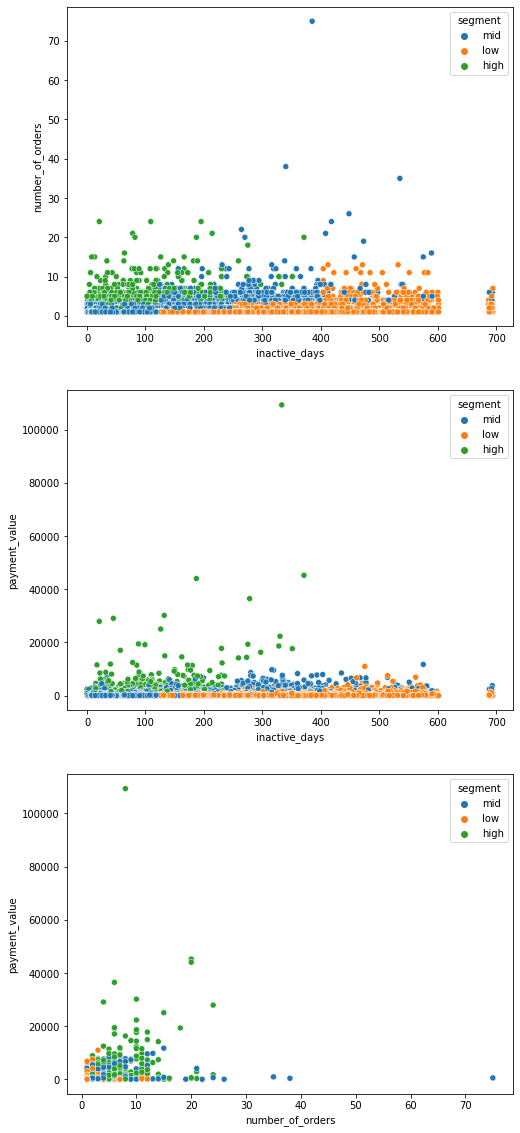

In [128]:
fig, ax = plt.subplots(3, 1, figsize=(8,20))
sns.scatterplot(x='inactive_days', y='number_of_orders', ax=ax[0], hue='segment', data=overall)
sns.scatterplot(x='inactive_days', y='payment_value', ax=ax[1], hue='segment', data=overall)
sns.scatterplot(x='number_of_orders', y='payment_value', ax=ax[2], hue='segment', data=overall);

As seen from the scatterplots above, the RFM framework helps us to clearly differentiate the low, mid and high segments.

## Conclusions

Now that we have identified our segments, each customer segment needs to be targeted differently:

* High value: Maintain share of wallet. This can be done by personalising the shopping experience and introducing exclusive rewards to promote loyalty and advocacy.

* Mid value: The mid segment (1.39 orders) has a much lower average order frequency than the high segment (5.35 orders). We should focus on improving frequency among mid value customers. We can also investigate if customers have had a bad experience which is deterring them from purchasing more frequently. Addressing these pain points will be crucial in driving frequency.

* Low value: This group has very high platform inactivity, averaging at 310 inactive days. Awareness may be an issue with this group. Invest in paid ads, content marketing and organic social media posts to improve general awareness about Olist and its value proposition. After which, introduce gamification to encourage habitual platform use.
